# SARS-CoV-2 genome analysis with Biopython
LinkedIn: [Oleg Brezitskyy](https://www.linkedin.com/in/olegbrz/)

**Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome (GenBank: MN908947.3)**

Source: https://www.ncbi.nlm.nih.gov/nuccore/MN908947

<img src="sars.png" alt="translation" width="100"/>

---

## Installing biopyhton

In [2]:
!pip install biopython

  Using cached biopython-1.78-cp38-cp38-win_amd64.whl (2.3 MB)


## Getting the data

First, we need to get the virus sequence from NCBI trough Biopython. Our isolate id is `MN908947.3`.

In [3]:
from Bio import SeqIO
from Bio import Entrez
Entrez.email = 'breziskyyoleg@gmail.com'
handle = Entrez.efetch(db="nucleotide", id='MN908947.3', rettype="fasta", retmode="text")
record = SeqIO.read(handle, "fasta")
genome = str(record.seq)

Let's check if it's ok...

In [5]:
genome[:200]

'ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGT'

Let's see how much data has the genome:

In [6]:
import zlib
len(zlib.compress(genome.encode('utf-8')))/1024

8.6513671875

Wow! that's over **8 kB** of information!

## Preparing the data

Ok, now we need to clean and correct the sequence.

Thanks to NCBI, we know that the sequence has his **5'UTR and 3'UTR**, which are basically **untranslated regions**. We don't need them.

In this case we have:

- **5'UTR**: from 1 to 265
- **3'UTR**: from 29675 to 29903

The translation process also has a **-1 ribosomal frameshift** at $13468^{th}$ place, which means that the ribosome slips back one nucleotide and continues translation in the −1 frame.

![-1 ribosomal frameshifting](frameshift.jpg)

We will do the same here:

In [7]:
genome = genome[265:13468] + genome[13467:29674]

Let's see the first 500 bases:

In [8]:
 genome[:200]

'ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCC'

## Let's do the magic

In [12]:
from Bio.Seq import Seq

Now we create a new `Seq` object with `genome` sequence and `generic_dna` alphabet:

In [11]:
dna = Seq(genome)
dna

Seq('ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTG...TAG')

### Sequence transcription (DNA $\rightarrow$ RNA)

Now we are going to transcript the DNA sequence into RNA.

In [13]:
rna = dna.transcribe()
rna

Seq('AUGGAGAGCCUUGUCCCUGGUUUCAACGAGAAAACACACGUCCAACUCAGUUUG...UAG')

It is the same except that T's are U's now.

### Nucleotide frequencies

Let's count the nucleotide frequencies in the transcripted RNA

In [46]:
freq_calc = lambda count: round(rna.count(count)/len(rna)*100,2)

nucl_freq = {
    'A': freq_calc('A'),
    'U': freq_calc('U'),
    'G':freq_calc('G'),
    'C': freq_calc('C')
}

In [47]:
nucl_freq

{'A': 29.9, 'U': 32.17, 'G': 19.59, 'C': 18.34}

As it can be seen, the frequencies are:

- **A**: 29.9%
- **U**: 32.17%
- **G**: 19.59%
- **C**: 18.34%

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

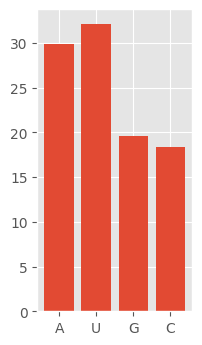

In [49]:
fig=plt.figure(figsize=(2, 4), dpi=100)
plt.bar(nucl_freq.keys(),nucl_freq.values(), align='center')
plt.show()

### RNA translation

<img src="translation.png" alt="translation" width="700"/>


Now we will translate the RNA sequence to amino acids with the standard table:

In [14]:
from Bio.Data import CodonTable
print(CodonTable.unambiguous_rna_by_name['Standard'])

Table 1 Standard, SGC0

  |  U      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
U | UUU F   | UCU S   | UAU Y   | UGU C   | U
U | UUC F   | UCC S   | UAC Y   | UGC C   | C
U | UUA L   | UCA S   | UAA Stop| UGA Stop| A
U | UUG L(s)| UCG S   | UAG Stop| UGG W   | G
--+---------+---------+---------+---------+--
C | CUU L   | CCU P   | CAU H   | CGU R   | U
C | CUC L   | CCC P   | CAC H   | CGC R   | C
C | CUA L   | CCA P   | CAA Q   | CGA R   | A
C | CUG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | AUU I   | ACU T   | AAU N   | AGU S   | U
A | AUC I   | ACC T   | AAC N   | AGC S   | C
A | AUA I   | ACA T   | AAA K   | AGA R   | A
A | AUG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GUU V   | GCU A   | GAU D   | GGU G   | U
G | GUC V   | GCC A   | GAC D   | GGC G   | C
G | GUA V   | GCA A   | GAA E   | GGA G   | A
G | GUG V   | GCG A   | GAG E   | GGG G   | G
--+---------

Note that we set the argument `to_stop` as `True` which means that the translation will stop at the next stop codon. We don't need more as the entire genome has a lot of proteins.

In [50]:
amino_seq = rna.translate(table='Standard', to_stop=True)
amino_seq

c:\python3\lib\site-packages\Bio\Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLV...VNN')

And eureka! We just discovered the [**orf1ab polyprotein**](https://www.ncbi.nlm.nih.gov/protein/1791269089)! The raised error is due to the ribosomal frameshift.

![orf1ab polyprotein](orf1b_polyprotein.png)

In [51]:
str(amino_seq)[:200]

'MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRELMRELNGGAYTRYVDNNFCGPDGYPLEC'

In [52]:
f'Protein lenghth: {len(amino_seq)}'

'Protein lenghth: 7096'

### Protein analysis with biopython

We also can analyse the protein with `SeqUtils`:

In [53]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

We start creating `ProteinAnalysis` object with the protein sequence.

In [54]:
protein = ProteinAnalysis(str(amino_seq))

Let's compute the molecular weight of the protein:

In [55]:
round(protein.molecular_weight()/1000, 2)

794.05

That means that the protein weights **794.05 kDa**.

We can also check the amino acids count:

In [56]:
amino_acids_count = protein.count_amino_acids()
amino_acids_count

{'A': 487,
 'C': 226,
 'D': 389,
 'E': 340,
 'F': 349,
 'G': 412,
 'H': 145,
 'I': 343,
 'K': 434,
 'L': 668,
 'M': 168,
 'N': 384,
 'P': 274,
 'Q': 239,
 'R': 244,
 'S': 456,
 'T': 527,
 'V': 598,
 'W': 78,
 'Y': 335}

Let's plot that!

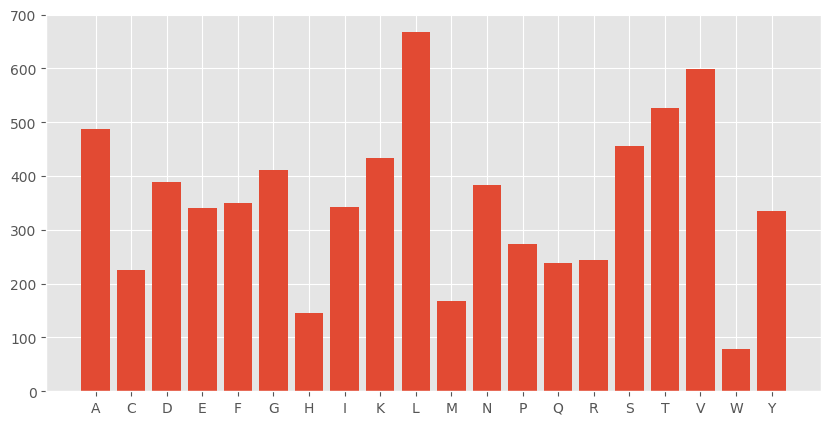

In [18]:
fig=plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(len(amino_acids_count)), list(amino_acids_count.values()), align='center')
plt.xticks(range(len(amino_acids_count)), list(amino_acids_count.keys()))

plt.show()

---